## [Import data]

In [1]:
!pip install pandas==2.2.1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import RobustScaler
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==2.2.1
numpy==1.26.4
seaborn==0.13.2


In [3]:
TRAIN_INPUT = "data/x_train.csv"
TRAIN_OUTPUT = "data/y_train.csv"
TEST_INPUT = "data/x_test.csv"

In [130]:
x_train_raw = pd.read_csv(TRAIN_INPUT, index_col= 'DELIVERY_START', parse_dates=True)
y_train_raw = pd.read_csv(TRAIN_OUTPUT, index_col= 'DELIVERY_START', parse_dates=True)
x_test_raw = pd.read_csv(TEST_INPUT, index_col= 'DELIVERY_START', parse_dates=True)

In [131]:
x_test_raw.index

DatetimeIndex(['2023-04-02 00:00:00+02:00', '2023-04-02 01:00:00+02:00',
               '2023-04-02 02:00:00+02:00', '2023-04-02 03:00:00+02:00',
               '2023-04-02 04:00:00+02:00', '2023-04-02 05:00:00+02:00',
               '2023-04-02 06:00:00+02:00', '2023-04-02 07:00:00+02:00',
               '2023-04-02 08:00:00+02:00', '2023-04-02 09:00:00+02:00',
               ...
               '2023-10-24 14:00:00+02:00', '2023-10-24 15:00:00+02:00',
               '2023-10-24 16:00:00+02:00', '2023-10-24 17:00:00+02:00',
               '2023-10-24 18:00:00+02:00', '2023-10-24 19:00:00+02:00',
               '2023-10-24 20:00:00+02:00', '2023-10-24 21:00:00+02:00',
               '2023-10-24 22:00:00+02:00', '2023-10-24 23:00:00+02:00'],
              dtype='datetime64[ns, UTC+02:00]', name='DELIVERY_START', length=4942, freq=None)

In [132]:
#datetime data
x_train = x_train_raw.set_index(pd.to_datetime(x_train_raw.index, utc=True))
y_train = y_train_raw.set_index(pd.to_datetime(y_train_raw.index, utc=True))
x_test = x_test_raw.set_index(pd.to_datetime(x_test_raw.index, utc=True))

In [133]:
print(f"Training data : from {x_train.index.min()} to {x_train.index.max()}")
print(f"Test data : from {x_test.index.min()} to {x_test.index.max()}")

Training data : from 2022-01-01 01:00:00+00:00 to 2023-03-29 21:00:00+00:00
Test data : from 2023-04-01 22:00:00+00:00 to 2023-10-24 21:00:00+00:00


https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?q.timerange.date=date:%5B2021-12-31T23:00:00Z+TO+2023-10-24T21:59:59Z%5D&refine.nom=ORLY&refine.nom_reg=%C3%8Ele-de-France&sort=-date

In [134]:
temp = pd.read_csv('data/ods_temperature.csv', encoding='latin-1', sep=';', parse_dates=True)
temp.head()

,Date,Température (°C)
0,2022-01-01T01:00:00+01:00,9.7
1,2022-01-01T04:00:00+01:00,8.9
2,2022-01-01T07:00:00+01:00,7.8
3,2022-01-01T10:00:00+01:00,7.5
4,2022-01-01T13:00:00+01:00,12.2


In [135]:
temp.Date = pd.to_datetime(temp.Date, utc=True)

In [136]:
temp.set_index('Date', inplace=True)
temp.head()

,Température (°C)
Date,
2022-01-01 00:00:00+00:00,9.7
2022-01-01 03:00:00+00:00,8.9
2022-01-01 06:00:00+00:00,7.8
2022-01-01 09:00:00+00:00,7.5
2022-01-01 12:00:00+00:00,12.2


In [137]:
temp = temp.resample('1h').mean().interpolate()

In [138]:
# all = pd.concat((x_train,x_test)).resample('1h').mean()
# null_indices = all['predicted_spot_price'][all['predicted_spot_price'].isnull()].index
# non_null_indices = pd.DatetimeIndex([i for i in all.index if i not in null_indices])
# for date in non_null_indices:
#     all.loc[(all.index.dayofyear==date.dayofyear)&(all.index.hour==date.hour),'predicted_spot_price']=all.loc[date,'predicted_spot_price']
# x_train['predicted_spot_price'] = all.loc[x_train.index,'predicted_spot_price']

In [139]:
from src.processing import process_features,process_target

x_train_processed, x_test_processed, original_x_train_indices, original_x_test_indices = process_features(x_train, x_test, impute_nan=True)
y_train_processed, original_y_train_indices = process_target(y_train, impute_nan=True)

COLUMN :  load_forecast
COLUMN :  coal_power_available
Could not decompose coal_power_available into trend/seasonality, doing simple interpolation
COLUMN :  gas_power_available
COLUMN :  nucelear_power_available
COLUMN :  wind_power_forecasts_average
COLUMN :  solar_power_forecasts_average
COLUMN :  wind_power_forecasts_std
COLUMN :  solar_power_forecasts_std
COLUMN :  predicted_spot_price
Could not decompose predicted_spot_price into trend/seasonality, doing simple interpolation
COLUMN :  original
Could not decompose original into trend/seasonality, doing simple interpolation
COLUMN :  load_forecast
COLUMN :  coal_power_available
COLUMN :  gas_power_available
COLUMN :  nucelear_power_available
COLUMN :  wind_power_forecasts_average
COLUMN :  solar_power_forecasts_average
COLUMN :  wind_power_forecasts_std
COLUMN :  solar_power_forecasts_std
COLUMN :  predicted_spot_price
Could not decompose predicted_spot_price into trend/seasonality, doing simple interpolation
COLUMN :  original
COLU

In [140]:
len(original_y_train_indices)/y_train_processed.shape[0]

0.9757107369583218

In [141]:
null_indices = x_train_processed.loc[x_train_processed['predicted_spot_price'].isna()].index
non_null_indices = [i for i in x_train_processed.index if i not in null_indices]

### Feature engineering (categorical and lags)
* SUNLIGHT : (0 or 1), à partir des éphémérides de la journée 
* JOURNEES SPECIALES : Dummy variables for Mondays, Saturdays, Sundays, Holidays (France)
* LAGS : Lags de la variable cible $\{6,12,24,24*2,24*3,24*7,24*10,24*15,24*30\}$
* ECART OFFRE DEMANDE : conso - prod
* LAGS : Lags de conso-prod $\{6,12,24,-6,-12,-24\}$
* TEMPERATURE : Température horaire France

In [142]:
# # LAGGED TARGET -----------------------------------------------------
# for i in [6,12,24,24*2,24*3,24*7]:
#     x_train_processed[f'target_lag_{i}'] = y_train_processed.shift(i)

In [143]:
# SUNLIGHT -----------------------------------------------------------
from datetime import datetime
from suntimes import SunTimes  
day = datetime(2024,3,13)
paris = SunTimes(2.349902, 48.852968, 35)
print(paris.riseutc(day))

x_train_processed['sunrise'] = x_train_processed.index.map(lambda x: paris.riseutc(x))
x_train_processed['sunset'] = x_train_processed.index.map(lambda x: paris.setutc(x))
x_train_processed['sunlight'] = 0
x_train_processed.loc[(x_train_processed.index>= x_train_processed.sunrise) & (x_train_processed.index<=x_train_processed.sunset),'sunlight']=1
x_train_processed.drop(['sunrise','sunset'], axis=1, inplace=True)

x_test_processed['sunrise'] = x_test_processed.index.map(lambda x: paris.riseutc(x))
x_test_processed['sunset'] = x_test_processed.index.map(lambda x: paris.setutc(x))
x_test_processed['sunlight'] = 0
x_test_processed.loc[(x_test_processed.index>= x_test_processed.sunrise) & (x_test_processed.index<=x_test_processed.sunset),'sunlight']=1
x_test_processed.drop(['sunrise','sunset'], axis=1, inplace=True)

2024-03-13 06:08:00


In [144]:
# # JOURNEES SPECIALES -----------------------------------------
# #Monday, Saturday, Sunday
# x_train_small['monday'] = (x_train_small.index.dayofweek == 0).astype(int)
# x_train_small['saturday'] = (x_train_small.index.dayofweek == 5).astype(int)
# x_train_small['sunday'] = (x_train_small.index.dayofweek == 6).astype(int)

# x_test_processed['monday'] = (x_test_processed.index.dayofweek == 0).astype(int)
# x_test_processed['saturday'] = (x_test_processed.index.dayofweek == 5).astype(int)
# x_test_processed['sunday'] = (x_test_processed.index.dayofweek == 6).astype(int)

In [145]:
# Jours fériés
from jours_feries_france import JoursFeries

holidays = []
for year in [2022, 2023]:
    holidays += list(JoursFeries.for_year(year).values())

x_train_processed['holiday'] = 0
for holiday in holidays:
    x_train_processed.loc[x_train_processed.index.date == holiday, 'holiday'] = 1

x_test_processed['holiday'] = 0
for holiday in holidays:
    x_test_processed.loc[x_test_processed.index.date == holiday, 'holiday'] = 1


In [146]:
# TEMPERATURE --------------------------------------------------
from sklearn.preprocessing import StandardScaler

x_train_processed['temperature'] = temp.loc[x_train_processed.index, 'Température (°C)']
x_test_processed['temperature'] = temp.loc[x_test_processed.index, 'Température (°C)']
scaler = StandardScaler()
x_train_processed['temperature'] = scaler.fit_transform(pd.DataFrame(x_train_processed['temperature']))
x_test_processed['temperature'] = scaler.transform(pd.DataFrame(x_test_processed['temperature']))

In [147]:
x_train_small = x_train_processed.loc[non_null_indices,:]
y_train_small = y_train_processed.loc[non_null_indices,:]
x_train_small

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,conso_prod_delta,month_rad,hour_rad,weekday_rad,dayofyear_rad,sunlight,holiday,temperature
DELIVERY_START,,,,,,,,,,,,,,,,,
2023-01-03 00:00:00+00:00,-0.392943,1.152269,1.000857,0.928201,-0.209653,-0.713405,-0.464296,-0.587373,-0.674089,-1.202486,0.523599,0.000000,0.897598,0.051643,0,0,-0.861275
2023-01-03 01:00:00+00:00,-0.451817,1.152269,1.000857,0.928201,-0.137003,-0.713405,-0.290878,-0.587373,-0.801559,-1.317172,0.523599,0.261799,0.897598,0.051643,0,0,-0.896824
2023-01-03 02:00:00+00:00,-0.631250,1.152269,1.000857,0.928201,-0.086661,-0.713405,-0.435678,-0.587373,-0.960448,-1.593578,0.523599,0.523599,0.897598,0.051643,0,0,-0.932372
2023-01-03 03:00:00+00:00,-0.692573,1.152269,1.000857,0.928201,-0.038429,-0.713405,-0.498970,-0.587373,-1.270447,-1.701306,0.523599,0.785398,0.897598,0.051643,0,0,-0.967921
2023-01-03 04:00:00+00:00,-0.474858,1.152269,1.000857,0.928201,0.002267,-0.713405,-0.582115,-0.587373,-1.184569,-1.409436,0.523599,1.047198,0.897598,0.051643,0,0,-0.910154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-29 17:00:00+00:00,-0.162619,1.152269,1.015195,0.392532,0.923799,-0.472440,0.934240,-0.404489,-0.876665,-0.919250,1.570796,4.450590,1.795196,1.514850,1,0,0.987254
2023-03-29 18:00:00+00:00,-0.179492,1.152269,1.015195,0.392532,1.160739,-0.673059,0.233643,-0.528122,-0.351523,-0.974660,1.570796,4.712389,1.795196,1.514850,1,0,0.938375
2023-03-29 19:00:00+00:00,-0.399656,1.152269,1.015195,0.392532,1.394965,-0.713405,0.012556,-0.587373,0.018021,-1.373484,1.570796,4.974188,1.795196,1.514850,0,0,0.885052


In [148]:
from src.metrics import weighted_accuracy
def evaluate(model, features, target, indices):
    predictions = model.predict(features.loc[indices]) *2 - 1
    target = target.loc[indices]
    return weighted_accuracy(target,predictions)

In [149]:
N_train = int(len(x_train_small)*0.8)
dates_indices = [i for i in non_null_indices if i in x_train_processed.iloc[original_x_train_indices].index]
x_train_eval, x_valid_eval, train_indices, valid_indices = x_train_small[:N_train], x_train_small[N_train:], dates_indices[:N_train], dates_indices[N_train:]
y_train_eval, y_valid_eval = y_train_small[:N_train], y_train_small[N_train:]
y_train_eval_cls, _ = process_target(y_train_eval, binarize=True)
y_valid_eval_cls, _ = process_target(y_valid_eval, binarize=True)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=np.random.seed(1234))
clf.fit(x_train_eval, y_train_eval_cls)
evaluate(clf, x_valid_eval, y_valid_eval, valid_indices)


0.7208173167671877

In [150]:
x_test_processed['predicted_spot_price'] = x_test_processed['predicted_spot_price'].fillna(method='ffill').fillna(0)

C:\Users\TRETEC\AppData\Local\Temp\ipykernel_6972\2991766688.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x_test_processed['predicted_spot_price'] = x_test_processed['predicted_spot_price'].fillna(method='ffill').fillna(0)


([<matplotlib.axis.XTick at 0x1c5c74f7750>,
 [Text(0.0, 0, 'load_forecast'),
  Text(1.0, 0, 'coal_power_available'),
  Text(2.0, 0, 'gas_power_available'),
  Text(3.0, 0, 'nucelear_power_available'),
  Text(4.0, 0, 'wind_power_forecasts_average'),
  Text(5.0, 0, 'solar_power_forecasts_average'),
  Text(6.0, 0, 'wind_power_forecasts_std'),
  Text(7.0, 0, 'solar_power_forecasts_std'),
  Text(8.0, 0, 'predicted_spot_price'),
  Text(9.0, 0, 'conso_prod_delta'),
  Text(10.0, 0, 'month_rad'),
  Text(11.0, 0, 'hour_rad'),
  Text(12.0, 0, 'weekday_rad'),
  Text(13.0, 0, 'dayofyear_rad'),
  Text(14.0, 0, 'sunlight'),
  Text(15.0, 0, 'holiday'),
  Text(16.0, 0, 'temperature')])

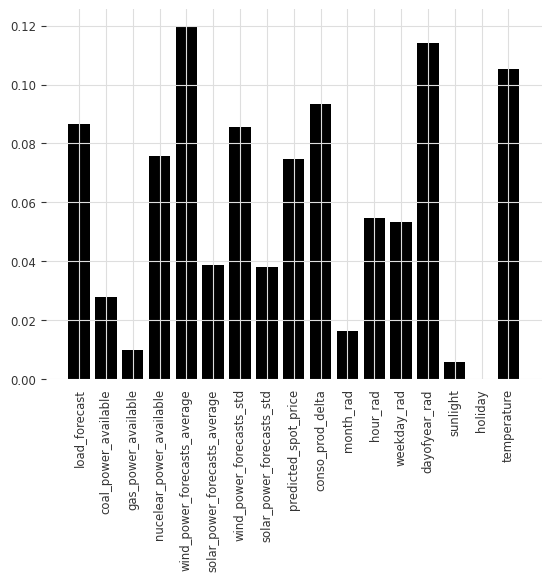

In [151]:
clf.feature_importances_
clf.feature_names_in_
plt.bar(clf.feature_names_in_,clf.feature_importances_)
plt.xticks(clf.feature_names_in_, rotation='vertical')

In [116]:
x_test_processed.isna().sum()

load_forecast                    0
coal_power_available             0
gas_power_available              0
nucelear_power_available         0
wind_power_forecasts_average     0
solar_power_forecasts_average    0
wind_power_forecasts_std         0
solar_power_forecasts_std        0
predicted_spot_price             0
conso_prod_delta                 0
month_rad                        0
hour_rad                         0
weekday_rad                      0
dayofyear_rad                    0
sunlight                         0
holiday                          0
temperature                      0
dtype: int64

In [153]:
from datetime import datetime
y_test_pred = clf.predict(x_test_processed)*2 -1
y_test_pred = y_test_pred[original_x_test_indices]
submission = pd.DataFrame(y_test_pred, index=x_test_raw.index, columns=['spot_id_delta'])
model_name = 'rf'
descr = 'train_small'
submission.to_csv(f'submission/{datetime.today().date()}_{model_name}_{descr}.csv', index=True)